In [90]:
# Import Libraries
%matplotlib inline

import numpy as np
import pandas as pd
import pyspark as ps    # for the pyspark suitefrom collections import Counter
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use('ggplot')

In [91]:
# Import Custom Modules
from src.eda_helper import *


In [93]:
# Create spark session
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("capstone1") \
            .getOrCreate()
sc = spark.sparkContext

In [4]:
ls data/


All_Beauty_5.json  Books.json


In [5]:
# beauty ratings
path_beauty = "data/All_Beauty_5.json"


## Explore data in Beauty

In [6]:
# Create Spark DF
beauty_df = spark.read.json(path_beauty)
# Create Spark SQL
beauty_df.createOrReplaceTempView('beauty')
# Create Spark RDD
beauty_rdd = sc.textFile(path_beauty)

In [7]:
beauty_df.printSchema()

print(beauty_df.count())

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Scent Name:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)

5269


In [8]:
beauty_rdd.take(1)

['{"overall": 5.0, "verified": true, "reviewTime": "09 1, 2016", "reviewerID": "A3CIUOJXQ5VDQ2", "asin": "B0000530HU", "style": {"Size:": " 7.0 oz", "Flavor:": " Classic Ice Blue"}, "reviewerName": "Shelly F", "reviewText": "As advertised. Reasonably priced", "summary": "Five Stars", "unixReviewTime": 1472688000}']

In [9]:
# Map each RDD item to JSON
beauty_rdd_json = beauty_rdd.map(parse_json)

# Sample View
beauty_rdd_json.take(1)

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '09 1, 2016',
  'reviewerID': 'A3CIUOJXQ5VDQ2',
  'asin': 'B0000530HU',
  'style': {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'},
  'reviewerName': 'Shelly F',
  'reviewText': 'As advertised. Reasonably priced',
  'summary': 'Five Stars',
  'unixReviewTime': 1472688000}]

## How is the ratings distributed


### Extract 'overall' key from JSON Obects

In [31]:
overall_beauty = (beauty_rdd_json.filter(lambda row: row['verified'])
                  .map(lambda row: row['overall']))
overall_beauty.count()

4280

In [32]:
overall_beauty.take(10)

[5.0, 5.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [33]:
overall_beauty.mean()

4.814252336448603

In [164]:
overall_beauty.stdev()

0.7304029433749584

###  Pie Chart of overall_tags in Beauty

In [34]:
bins = [1,2,3,4,5]
cnt = Counter(overall_beauty.collect())
cnt

Counter({5.0: 3931, 1.0: 111, 2.0: 39, 4.0: 164, 3.0: 35})

In [35]:
# Create DF of ratings count
df_cnt_beauty = pd.DataFrame({'ratings': list(cnt.keys()),
                             'count': list(cnt.values())
})
df_cnt_beauty

,ratings,count
0,5.0,3931
1,1.0,111
2,2.0,39
3,4.0,164
4,3.0,35


Text(0.5, 1.0, 'Ratings count in Beauty')

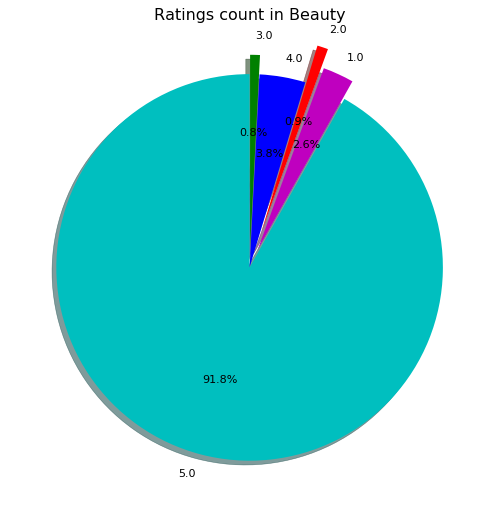

In [176]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=80)
labels = df_cnt_beauty['ratings'].values
sizes  = df_cnt_beauty['count'].values
cols = ['c','m','r','b','g']
# ax.bar(df_ratings['ratings'],df_ratings['count'])
ax.pie(sizes,
        labels=labels,
        startangle=90,
        shadow= True,
        colors=cols,
        explode=(0,0.1,0.2,0,0.1),
        autopct='%1.1f%%')

ax.set_title("Ratings count in Beauty")

## Average ratings in different years IN Beauty

In [102]:
years_beauty = (beauty_rdd_json.filter(lambda row: row['verified'])
                        .map(lambda row: row['reviewTime'])
                        .map(lambda row: row.split(","))
                        .map(lambda row: int(row[1]))
                       )
years_beauty.count()

4280

In [100]:
years_beauty.take(10)

[' 2016',
 ' 2013',
 ' 2013',
 ' 2011',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018',
 ' 2018']

In [61]:
# Extract years


In [55]:
overall_beauty.take(10)

[5.0, 5.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [107]:
# Create DF of years and ratings
df_years = pd.DataFrame({'ratings': overall_beauty.collect(),
                             'years': years_beauty.collect()
})
df_years.head(5)

,ratings,years
0,5.0,2016
1,5.0,2013
2,1.0,2013
3,5.0,2011
4,2.0,2018


In [113]:
ratings_by_year = pd.DataFrame(df_years.groupby('years')['ratings'].mean())
ratings_by_year

years
2007    4.333333
2008    3.666667
2009    4.500000
2011    4.600000
2012    4.894737
2013    4.951515
2014    4.933222
2015    4.957983
2016    4.940147
2017    4.939571
2018    3.448468
Name: ratings, dtype: float64

In [122]:
type(ratings_by_year)

pandas.core.series.Series

In [126]:
ratings_by_year.index

Int64Index([2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64', name='years')

In [139]:
avg_ratings = pd.DataFrame({'year': ratings_by_year.index.tolist(),
                  'avg_ratings': ratings_by_year})

avg_ratings.reset_index(drop=True, inplace=True)
avg_ratings

,year,avg_ratings
0,2007,4.333333
1,2008,3.666667
2,2009,4.500000
3,2011,4.600000
4,2012,4.894737
5,2013,4.951515
6,2014,4.933222
7,2015,4.957983
8,2016,4.940147
9,2017,4.939571


Text(0, 0.5, 'avg_ratings')

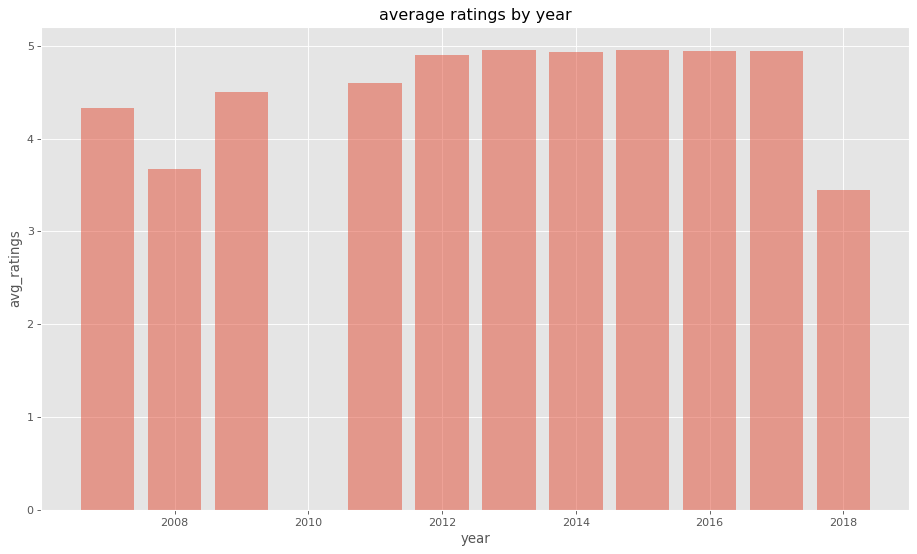

In [148]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=80)
ax.bar(avg_ratings['year'],avg_ratings['avg_ratings'],alpha=0.5)
ax.set_title("average ratings by year")
ax.set_xlabel("year")
ax.set_ylabel("avg_ratings")

## Explore data in Books

In [149]:
ls data/

AMAZON_FASHION_5.json  All_Beauty_5.json      Books_5.json


In [151]:
# Books ratings
path_books = "data/Books_5.json"

In [152]:
# Create Spark DF
books_df = spark.read.json(path_books)
# Create Spark SQL
books_df.createOrReplaceTempView('books')
# Create Spark RDD
books_rdd = sc.textFile(path_books)


In [153]:
books_df.printSchema()



root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



In [154]:
books_rdd.take(1)

['{"overall": 5.0, "verified": false, "reviewTime": "03 30, 2005", "reviewerID": "A1REUF3A1YCPHM", "asin": "0001713353", "style": {"Format:": " Hardcover"}, "reviewerName": "TW Ervin II", "reviewText": "The King, the Mice and the Cheese by Nancy Gurney is an excellent children\'s book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\\n\\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that\'d chased away the dogs.\\n\\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\\n\\nThe pictures that accompany the story are humorous and memorable.  I was th

In [155]:
# Map each RDD item to JSON
books_rdd_json = books_rdd.map(parse_json)

# Sample View
books_rdd_json.take(1)

[{'overall': 5.0,
  'verified': False,
  'reviewTime': '03 30, 2005',
  'reviewerID': 'A1REUF3A1YCPHM',
  'asin': '0001713353',
  'style': {'Format:': ' Hardcover'},
  'reviewerName': 'TW Ervin II',
  'reviewText': "The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\n\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs.\n\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\n\nThe pictures that accompany the story are humorous and memorable.  I w

In [161]:
overall_books =(books_rdd_json.filter(lambda row: row['verified'])
                  .map(lambda row: row['overall'])
           )


In [162]:
overall_books.take(5)

[5.0, 5.0, 5.0, 5.0, 5.0]

In [163]:
overall_books.mean()

4.425847125430551

In [165]:
overall_books.stdev()

0.9661424119905437

In [167]:
years_books = (books_rdd_json.filter(lambda row: row['verified'])
                        .map(lambda row: row['reviewTime'])
                        .map(lambda row: row.split(","))
                        .map(lambda row: int(row[1]))
                       )
years_books.take(10)

[2016, 2016, 2015, 2013, 2013, 2012, 2016, 2015, 2015, 2014]

In [173]:
df_years_books = pd.DataFrame({'ratings': overall_books.collect(),
                             'years': years_books.collect()
})
df_years_books.head(5)

,ratings,years
0,5.0,2016
1,5.0,2016
2,5.0,2015
3,5.0,2013
4,5.0,2013


In [174]:
ratings_by_year = pd.DataFrame(df_years.groupby('years')['ratings'].mean())
ratings_by_year

,ratings
years,
2007,4.333333
2008,3.666667
2009,4.500000
2011,4.600000
2012,4.894737
2013,4.951515
2014,4.933222
2015,4.957983
2016,4.940147


In [177]:
bins = [1,2,3,4,5]
cnt_books = Counter(overall_books.collect())
cnt_books

Counter({5.0: 12039326,
         2.0: 632423,
         4.0: 3653877,
         1.0: 482549,
         3.0: 1521282,
         0.0: 1})

In [178]:
# Create DF of ratings count
df_cnt_books = pd.DataFrame({'ratings': list(cnt_books.keys()),
                             'count': list(cnt_books.values())
})
df_cnt_books


,ratings,count
0,5.0,12039326
1,2.0,632423
2,4.0,3653877
3,1.0,482549
4,3.0,1521282
5,0.0,1


Text(0.5, 1.0, 'Ratings count in Books')

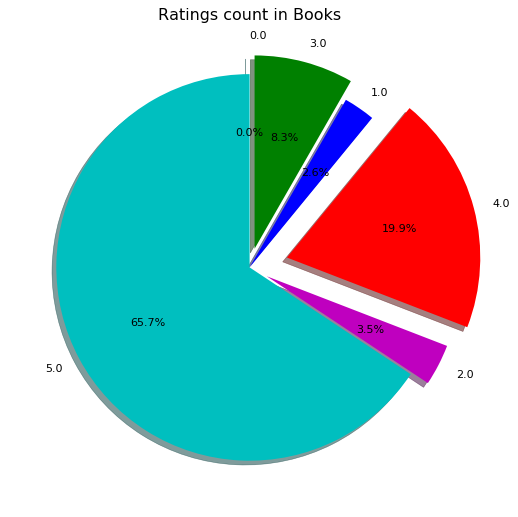

In [181]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=80)
labels = df_cnt_books['ratings'].values
sizes  = df_cnt_books['count'].values
cols = ['c','m','r','b','g']
# ax.bar(df_ratings['ratings'],df_ratings['count'])
ax.pie(sizes,
        labels=labels,
        startangle=90,
        shadow= True,
        colors=cols,
        explode=(0,0.1,0.2,0,0.1,0.1),
        autopct='%1.1f%%')

ax.set_title("Ratings count in Books")

In [180]:
labels = df_cnt_books['ratings'].values
labels

array([5., 2., 4., 1., 3., 0.])

## Explore data in Fashion 